# *I HAVE CODED THIS NOTEBOOK IN PYTHON 3, THAT IS WHY I HAD TO COPY face_generator.py PROGRAM AND MAKE A FEW CHANGES TO IT SO THAT IT SUPPORTS EXECUTION IN PYTHON 3 ENVIRONMENT.*

## Deep face recognition with Keras

In [0]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Set files_zip_path to the location in the drive where you have the new `'Files_required_for_face_recognition.zip'` file. This block will extract all the files to the current working directory. You should be seeing the list of all files inside the zip files as the output of this block after the final `!ls` command is executed. 

In [0]:
files_zip_path = "/content/drive/My Drive/ComputerVision_with_CNNs/Projects/Face Recognition/files_required_for_face_recognition-20190927T050655Z-001.zip"

import zipfile
#This extracts the files to the current working directory
archive = zipfile.ZipFile(files_zip_path, 'r')
archive.extractall()
!ls

drive  files_required_for_face_recognition  requirements.txt  sample_data


In [0]:
import os
#os.chdir('/content/drive/My Drive/ComputerVision_with_CNNs/Projects/Face Recognition/files_required_for_face_recognition')
#project_path = '/content/drive/My Drive/ComputerVision_with_CNNs/Projects/Face Recognition/files_required_for_face_recognition'
os.chdir('files_required_for_face_recognition')
project_path = 'files_required_for_face_recognition'

### First, lets install the required libraries. Upload the `requirements.txt` file given and run the below commands.

In [0]:
!ls

 align.py			   mobilenet_1_0_224_tf.h5
 data.py			   model.png
 dataset			   model.py
 _DS_Store			   nn4.small2.v1.h5
'_DS_Store(1)'			   predictor.py
 FACE_DETECTION_Questions.ipynb    __pycache__
 face_generator.py		   requirements.txt
 face_generator.pyc		   ssd_box_encode_decode_utils.py
 _gitattributes			   ssd_box_encode_decode_utils.pyc
 _gitignore			   ssd_mobilenet_face_epoch_25_loss0.0916.h5
 images				   utils.py
 images.zip			   wider_extract.py
 keras_layer_AnchorBoxes.py	   WIDER_train
 keras_layer_AnchorBoxes.pyc	   wider_train_small.npy
 keras_layer_L2Normalization.py    wider_train_v1.npy
 keras_layer_L2Normalization.pyc   WIDER_train.zip
 keras_ssd_loss.py		   WIDER_val
 keras_ssd_loss.pyc		   wider_val_small.npy
 __MACOSX			   wider_val_v1.npy
 mn_model.py			   WIDER_val.zip
 mn_model.pyc


In [0]:
os.chdir('/content')

In [0]:
!ls

drive  files_required_for_face_recognition  requirements.txt  sample_data


In [0]:
!pip install -r requirements.txt --user

In [0]:
import sys
sys.path.append('/root/.local/bin')

In [0]:
!pip install request

### Training the network

The CNN model is taken from the Keras-OpenFace project. The architecture details aren't too important here, it's only useful to know that there is a fully connected layer with 128 hidden units followed by an L2 normalization layer on top of the convolutional base. These two top layers are referred to as the embedding layer from which the 128-dimensional embedding vectors can be obtained. The complete model is defined in `model.py` and a graphical overview is given in `model.png`. A Keras version of the `nn4.small2` model can be created with `create_model()`.


**Run the below code to initialize the model**

In [0]:
os.chdir('files_required_for_face_recognition')

In [0]:
from model import create_model
#Disable tensorflow backend warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

nn4_small2 = create_model()

Using TensorFlow backend.


#### Idea of Training the model with Triplet loss function 

Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. This can be achieved with a triplet loss L that is minimized when the distance between an anchor image xai and a positive image xpi (same identity) in embedding space is smaller than the distance between that anchor image and a negative image xni (different identity) by at least a margin α.

In [0]:
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Layer

# Input for anchor, positive and negative images
in_a = Input(shape=(96, 96, 3))
in_p = Input(shape=(96, 96, 3))
in_n = Input(shape=(96, 96, 3))

# Output for anchor, positive and negative embedding vectors
# The nn4_small model instance is shared (Siamese network)
emb_a = nn4_small2(in_a)
emb_p = nn4_small2(in_p)
emb_n = nn4_small2(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
nn4_small2_train = Model([in_a, in_p, in_n], triplet_loss_layer)

In [0]:
from data import triplet_generator

# triplet_generator() creates a generator that continuously returns 
# ([a_batch, p_batch, n_batch], None) tuples where a_batch, p_batch 
# and n_batch are batches of anchor, positive and negative RGB images 
# each having a shape of (batch_size, 96, 96, 3).
generator = triplet_generator() 

nn4_small2_train.compile(loss=None, optimizer='adam')
nn4_small2_train.fit_generator(generator, epochs=10, steps_per_epoch=100)

# Please note that the current implementation of the generator only generates 
# random image data. The main goal of this code snippet is to demonstrate 
# the general setup for model training. In the following, we will anyway 
# use a pre-trained model so we don't need a generator here that operates 
# on real training data.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
100/100 [==============================] - 40s 395ms/step - loss: 0.8072
Epoch 2/10
100/100 [==============================] - 20s 196ms/step - loss: 0.8008
Epoch 3/10
100/100 [==============================] - 20s 198ms/step - loss: 0.7999
Epoch 4/10
100/100 [==============================] - 20s 196ms/step - loss: 0.8046
Epoch 5/10
100/100 [==============================] - 20s 196ms/step - loss: 0.8011
Epoch 6/10
100/100 [==============================] - 20s 197ms/step - loss: 0.8006
Epoch 7/10
100/100 [==============================] - 20s 196ms/step - loss: 0.8010
Epoch 8/10
100/100 [==============================] - 20s 197ms/step - loss: 0.8000
Epoch 9/10
100/100 [==============================] - 20s 197ms/step - loss: 0.8005
Epoch 10/10
100/100 [==============================] - 20s 196ms/step - loss: 0.8000


For this project, we are considering a pre-trained model given in file path **`nn4.small2.v1.h5`**.

# 1. Using **load_weights()** function load the given pre-trained weight file.

In [0]:
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('nn4.small2.v1.h5')

### Dataset

To demonstrate face recognition on a custom dataset, a small dataset is used. It consists of around 15-25 face images of 10 different persons. The metadata for each image (file and identity name) are loaded into memory for later processing.


Upload Images zip file given to drive and download and extract it using the below code. And we will pass the folder `images` to `load_metadata` function to save all the images filenames and person numbers.

#### Import drive module from google.colab

In [0]:
from google.colab import drive

#### Give a path to mount the files in your drive

In [0]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Using the above given mounted path, give the images.zip path dependent on where you placed the file in your drive.

In [0]:
!ls

 align.py			   mobilenet_1_0_224_tf.h5
 data.py			   model.png
 dataset			   model.py
 _DS_Store			   nn4.small2.v1.h5
'_DS_Store(1)'			   predictor.py
 FACE_DETECTION_Questions.ipynb    __pycache__
 face_generator.py		   requirements.txt
 face_generator.pyc		   ssd_box_encode_decode_utils.py
 _gitattributes			   ssd_box_encode_decode_utils.pyc
 _gitignore			   ssd_mobilenet_face_epoch_25_loss0.0916.h5
 images				   utils.py
 images.zip			   wider_extract.py
 keras_layer_AnchorBoxes.py	   WIDER_train
 keras_layer_AnchorBoxes.pyc	   wider_train_small.npy
 keras_layer_L2Normalization.py    wider_train_v1.npy
 keras_layer_L2Normalization.pyc   WIDER_train.zip
 keras_ssd_loss.py		   WIDER_val
 keras_ssd_loss.pyc		   wider_val_small.npy
 __MACOSX			   wider_val_v1.npy
 mn_model.py			   WIDER_val.zip
 mn_model.pyc


In [0]:
## For example
images_path = "./images.zip"

#### Using ZipFile module to extract the images zip file

In [0]:
from zipfile import ZipFile

In [0]:
with ZipFile(images_path, 'r') as zip:
  zip.extractall()

In [0]:
!ls

 align.py			   mobilenet_1_0_224_tf.h5
 data.py			   model.png
 dataset			   model.py
 _DS_Store			   nn4.small2.v1.h5
'_DS_Store(1)'			   predictor.py
 FACE_DETECTION_Questions.ipynb    __pycache__
 face_generator.py		   requirements.txt
 face_generator.pyc		   ssd_box_encode_decode_utils.py
 _gitattributes			   ssd_box_encode_decode_utils.pyc
 _gitignore			   ssd_mobilenet_face_epoch_25_loss0.0916.h5
 images				   utils.py
 images.zip			   wider_extract.py
 keras_layer_AnchorBoxes.py	   WIDER_train
 keras_layer_AnchorBoxes.pyc	   wider_train_small.npy
 keras_layer_L2Normalization.py    wider_train_v1.npy
 keras_layer_L2Normalization.pyc   WIDER_train.zip
 keras_ssd_loss.py		   WIDER_val
 keras_ssd_loss.pyc		   wider_val_small.npy
 __MACOSX			   wider_val_v1.npy
 mn_model.py			   WIDER_val.zip
 mn_model.pyc


#### Run the below function to load the images from the extracted images folder from the above step and map each image with person id 


In [0]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

In [0]:
print(metadata[0].file)

image_0328.jpg


In [0]:
print(metadata[1].image_path())

images/subject_8/image_0322.jpg


### Face Crop 
The nn4.small2.v1 model was trained with cropped face images, therefore, the face images from the custom dataset must be cropped too. Here, we use the face detection model we built in Milestone 2 and use it to detect faces and crop the faces to pass to our model.

##### 1. Import the pre-trained model from milestone 2. You would need all the python files required for the face-detection assignment and the trained weights as well


In [0]:
! python -c 'import keras; print(keras.__version__)'

Using TensorFlow backend.
2.2.4


In [0]:
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 2.8MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [0]:
!pip install tensorboard

In [0]:
'''
Includes:
* A batch generator for SSD model training and inference which can perform online data agumentation
* An offline image processor that saves processed images and adjusted labels to disk

Copyright (C) 2017 Pierluigi Ferrari

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
'''

import sys
import skimage
from skimage import transform

import numpy as np
import cv2
import random
from sklearn.utils import shuffle 
from copy import deepcopy
from PIL import Image
import csv
import os
import scipy.misc as sm
from bs4 import BeautifulSoup
from keras.applications.imagenet_utils import preprocess_input
from keras import backend as K
import os
from keras.preprocessing import image
import matplotlib as mpl 
mpl.use('Agg')
from matplotlib import pyplot as plt

from termcolor import colored
#from matplotlib import pyplot as plt 
from tqdm import tqdm
#from __future__ import print_function


# Error : TypeError: can't pickle generator objects


#from scipy.misc import imresize

#resize_fct = imresize
#resize_fct = np.array(Image.fromarray(arr).resize())

bb_expanded = False


def save_bb(path, filename, results, prediction=True):
  
  # print filename
  _SIZ = 300 
  # img = image.load_img(filename, target_size=(224, 224))
  img = image.load_img(filename)
  
  img_height = img.height 
  img_width = img.width

  img = image.img_to_array(img)

  filename = filename.split("/")[-1]

  if(not prediction):
    filename = filename[:-4] + "_gt" + ".jpg"

  #fig,currentAxis = plt.subplots(1)
  currentAxis = plt.gca()

 # Get detections with confidence higher than 0.6.
  colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
  color_code = min(len(results), 16)
  print (colored("total number of bbs: %d" % len(results), "yellow"))
  for result in results:
    # Parse the outputs.

    if(prediction):
      det_label = result[0]
      det_conf = result[1]
      det_xmin = result[2]
      det_xmax = result[3]
      det_ymin = result[4]
      det_ymax = result[5]
    else :
      det_label = result[0]
      det_xmin = result[1] * img_width / _SIZ
      det_xmax = result[2] * img_width / _SIZ
      det_ymin = result[3] * img_height / _SIZ
      det_ymax = result[4] * img_height / _SIZ
    

    
    xmin = int(det_xmin)
    ymin = int(det_ymin)
    xmax = int(det_xmax)
    ymax = int(det_ymax)

    if(prediction):
      score = det_conf
    
    plt.imshow(img / 255.)
    
    label = int(int(det_label))

    #print label
    # label_name = "seq_to_class_name[label]"


    label_name = "face"
    # label_name = class_names[label]
    # print label_name 
    # print label

    if(prediction):
      display_txt = '{:0.2f}, {}'.format(score, label_name)
    else:
      display_txt = '{}'.format(label_name)

      
    # print (xmin, ymin, ymin, ymax)
    coords = (xmin, ymin), (xmax-xmin), (ymax-ymin)
    color_code = color_code-1 
    color = colors[0]
    currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=1))
    # currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})

  plt.savefig(path + filename)

  print ('saved' , path + filename)

  plt.clf()
  

def classify(img_path):
    img_ = io.imread(img_path)
    #if grayscale > RGB
    if(len(img_.shape)==2):
        img_ = np.repeat(np.expand_dims(img_,-1),3,axis=-1)
    if(img_.shape[-1]==4):
        img_ = img_[:,:,0:3]
    img_ = resize_fct(img_,tuple(input_shape[0:2]))[:,:,::-1] - 128. #BGR - 128.
    img_ = np.expand_dims(img_,0) 

    prediction_ = sess.run('Sigmoid:0', feed_dict={'input_1:0': img_})
    return prediction_, img_



# import threading
# class threadsafe_iter:
    # def __init__(self, it):
        # self.it = it
        # self.lock = threading.Lock()

    # def __iter__(self):
        # return self

    # def next(self):
        # with self.lock:
            # return self.it.next()

# def threadsafe_generator(f):
    # def g(*a, **kw):
        # return threadsafe_iter(f(*a, **kw))
    # return g

# def preprocess_mobilenet_input(x):
    # x /= 255.
    # x -= 0.5
    # x *= 2.
    # return x

# Image processing functions used by the generator to perform the following image manipulations:
# - Translation
# - Horizontal flip
# - Scaling
# - Brightness change
# - Histogram contrast equalization

def _translate(image, horizontal=(0,40), vertical=(0,10)):
    '''
    Randomly translate the input image horizontally and vertically.

    Arguments:
        image (array-like): The image to be translated.
        horizontal (int tuple, optinal): A 2-tuple `(min, max)` with the minimum
            and maximum horizontal translation. A random translation value will
            be picked from a uniform distribution over [min, max].
        vertical (int tuple, optional): Analog to `horizontal`.

    Returns:
        The translated image and the horzontal and vertical shift values.
    '''
    rows,cols,ch = image.shape

    x = np.random.randint(horizontal[0], horizontal[1]+1)
    y = np.random.randint(vertical[0], vertical[1]+1)
    x_shift = random.choice([-x, x])
    y_shift = random.choice([-y, y])

    M = np.float32([[1,0,x_shift],[0,1,y_shift]])
    return cv2.warpAffine(image, M, (cols, rows)), x_shift, y_shift

def _flip(image, orientation='horizontal'):
    '''
    Flip the input image horizontally or vertically.
    '''
    if orientation == 'horizontal':
        return cv2.flip(image, 1)
    else:
        return cv2.flip(image, 0)

def _scale(image, min=0.9, max=1.1):
    '''
    Scale the input image by a random factor picked from a uniform distribution
    over [min, max].

    Returns:
        The scaled image, the associated warp matrix, and the scaling value.
    '''

    rows,cols,ch = image.shape

    #Randomly select a scaling factor from the range passed.
    scale = np.random.uniform(min, max)

    M = cv2.getRotationMatrix2D((cols/2,rows/2), 0, scale)
    return cv2.warpAffine(image, M, (cols, rows)), M, scale

def _brightness(image, min=0.5, max=2.0):
    '''
    Randomly change the brightness of the input image.

    Protected against overflow.
    '''
    hsv = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    random_br = np.random.uniform(min,max)

    #To protect against overflow: Calculate a mask for all pixels
    #where adjustment of the brightness would exceed the maximum
    #brightness value and set the value to the maximum at those pixels.
    mask = hsv[:,:,2] * random_br > 255
    v_channel = np.where(mask, 255, hsv[:,:,2] * random_br)
    hsv[:,:,2] = v_channel

    return cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

def histogram_eq(image):
    '''
    Perform histogram equalization on the input image.

    See https://en.wikipedia.org/wiki/Histogram_equalization.
    '''

    image1 = np.copy(image)

    image1[:,:,0] = cv2.equalizeHist(image1[:,:,0])
    image1[:,:,1] = cv2.equalizeHist(image1[:,:,1])
    image1[:,:,2] = cv2.equalizeHist(image1[:,:,2])

    return image1

class BatchGenerator:
    '''
    A generator to generate batches of samples and corresponding labels indefinitely.

    The labels are read from a CSV file.

    Shuffles the dataset consistently after each complete pass.

    Can perform image transformations for data conversion and data augmentation,
    for details please refer to the documentation of the `generate()` method.
    '''

    def __init__(self,
                 images_path,
                 include_classes='all',
                 box_output_format=['class_id', 'xmin', 'xmax', 'ymin', 'ymax']):
        '''
        Arguments:
            images_path (str): The filepath to the image samples.
            include_classes (list, optional): Either 'all' or a list of integers containing the class IDs that
                are to be included in the dataset. Defaults to 'all', in which case all boxes will be included
                in the dataset.
            box_output_format (list, optional): A list of five strings representing the desired order of the five
                items class ID, xmin, xmax, ymin, ymax in the generated data. The expected strings are
                'xmin', 'xmax', 'ymin', 'ymax', 'class_id'. If you want to train the model, this
                must be the order that the box encoding class requires as input. Defaults to
                `['class_id', 'xmin', 'xmax', 'ymin', 'ymax']`. Note that even though the parser methods are
                able to produce different output formats, the SSDBoxEncoder currently requires the format
                `['class_id', 'xmin', 'xmax', 'ymin', 'ymax']`. This list only specifies the five box parameters
                that are relevant as training targets, a list of filenames is generated separately.
        '''
        # These are the variables we always need
        self.images_path = images_path
        self.include_classes = include_classes
        self.box_output_format = box_output_format

        # These are the variables that we only need if we want to use parse_csv()
        self.labels_path = None
        self.input_format = None

        # These are the variables that we only need if we want to use parse_xml()
        self.annotations_path = None
        self.image_set_path = None
        self.image_set = None
        self.classes = None

        # The two variables below store the output from the parsers. This is the input for the generate() method
        # `self.filenames` is a list containing all file names of the image samples. Note that it does not contain the actual image files themselves.
        self.filenames = [] # All unique image filenames will go here
        # `self.labels` is a list containing one 2D Numpy array per image. For an image with `k` ground truth bounding boxes,
        # the respective 2D array has `k` rows, each row containing `(xmin, xmax, ymin, ymax, class_id)` for the respective bounding box.
        self.labels = [] # Each entry here will contain a 2D Numpy array with all the ground truth boxes for a given image

    def parse_csv(self,
                  labels_path=None,
                  input_format=None,
                  ret=False):
        '''
        Arguments:
            labels_path (str, optional): The filepath to a CSV file that contains one ground truth bounding box per line
                and each line contains the following six items: image file name, class ID, xmin, xmax, ymin, ymax.
                The six items do not have to be in a specific order, but they must be the first six columns of
                each line. The order of these items in the CSV file must be specified in `input_format`.
                The class ID is an integer greater than zero. Class ID 0 is reserved for the background class.
                `xmin` and `xmax` are the left-most and right-most absolute horizontal coordinates of the box,
                `ymin` and `ymax` are the top-most and bottom-most absolute vertical coordinates of the box.
                The image name is expected to be just the name of the image file without the directory path
                at which the image is located. Defaults to `None`.
            input_format (list, optional): A list of six strings representing the order of the six items
                image file name, class ID, xmin, xmax, ymin, ymax in the input CSV file. The expected strings
                are 'image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'. Defaults to `None`.
            ret (bool, optional): Whether or not the image filenames and labels are to be returned.
                Defaults to `False`.

        Returns:
            None by default, optionally the image filenames and labels.
        '''
        

        # If we get arguments in this call, set them
        if not labels_path is None: self.labels_path = labels_path
        if not input_format is None: self.input_format = input_format

        # Before we begin, make sure that we have a labels_path and an input_format
        if self.labels_path is None or self.input_format is None:
            raise ValueError("`labels_path` and/or `input_format` have not been set yet. You need to pass them as arguments.")

        # Erase data that might have been parsed before
        self.filenames = []
        self.labels = []

        # First, just read in the CSV file lines and sort them.

        data = []

        #print labels_path

        with open(self.labels_path) as csvfile:
            csvread = csv.reader(csvfile, delimiter=',')
            k = 0
            for i in csvread: # For every line (i.e for every bounding box) in the CSV file...
                if k == 0: # Skip the header row
                    k += 1
                    continue
                else:
                    if self.include_classes == 'all' or int(i[self.input_format.index('class_id')].strip()) in self.include_classes: # If the class_id is among the classes that are to be included in the dataset...
                        obj = [] # Store the box class and coordinates here
                        obj.append(i[self.input_format.index('image_name')].strip()) # Select the image name column in the input format and append its content to `obj`
                        for item in self.box_output_format: # For each item in the output format...
                            obj.append(int(i[self.input_format.index(item)].strip())) # ...select the respective column in the input format and append it to `obj`
                        data.append(obj)

        data = sorted(data) # The data needs to be sorted, otherwise the next step won't give the correct result

        # Now that we've made sure that the data is sorted by file names,
        # we can compile the actual samples and labels lists

        current_file = '' # The current image for which we're collecting the ground truth boxes
        current_labels = [] # The list where we collect all ground truth boxes for a given image
        for idx, i in enumerate(data):
            if current_file == '': # If this is the first image file
                current_file = i[0]
                current_labels.append(i[1:])
                if len(data) == 1: # If there is only one box in the CVS file
                    self.labels.append(np.stack(current_labels, axis=0))
                    self.filenames.append(current_file)
            else:
                if i[0] == current_file: # If this box (i.e. this line of the CSV file) belongs to the current image file
                    current_labels.append(i[1:])
                    if idx == len(data)-1: # If this is the last line of the CSV file
                        self.labels.append(np.stack(current_labels, axis=0))
                        self.filenames.append(current_file)
                else: # If this box belongs to a new image file
                    self.labels.append(np.stack(current_labels, axis=0))
                    self.filenames.append(current_file)
                    current_labels = []
                    current_file = i[0]
                    current_labels.append(i[1:])

        if ret: # In case we want to return these
            return self.filenames, self.labels

    def parse_xml(self,
                      annotations_path=None,
                      image_set_path=None,
                      image_set=None,
                      classes=['background',
                               'aeroplane', 'bicycle', 'bird', 'boat',
                               'bottle', 'bus', 'car', 'cat',
                               'chair', 'cow', 'diningtable', 'dog',
                               'horse', 'motorbike', 'person', 'pottedplant',
                               'sheep', 'sofa', 'train', 'tvmonitor'],
                      exclude_truncated=False,
                      exclude_difficult=False,
                      ret=False,
                      debug = False):
            '''
            This is a parser for the Pascal VOC datasets. It might be used for other datasets with minor changes to
            the code, but in its current form it expects the data format and XML tags of the Pascal VOC datasets.

            Arguments:
                annotations_path (str, optional): The path to the directory that contains the annotation XML files for
                    the images. The directory must contain one XML file per image and name of the XML file must be the
                    image ID. The content of the XML files must be in the Pascal VOC format. Defaults to `None`.
                image_set_path (str, optional): The path to the directory that contains a text file with the image
                    set to be loaded. Defaults to `None`.
                image_set (str, optional): The name of the image set text file to be loaded, ending in '.txt'.
                    This text file simply contains one image ID per line and nothing else. Defaults to `None`.
                classes (list, optional): A list containing the names of the object classes as found in the
                    `name` XML tags. Must include the class `background` as the first list item. The order of this list
                    defines the class IDs. Defaults to the list of Pascal VOC classes in alphabetical order.
                exclude_truncated (bool, optional): If `True`, excludes boxes that are labeled as 'truncated'.
                    Defaults to `False`.
                exclude_difficult (bool, optional): If `True`, excludes boxes that are labeled as 'difficult'.
                    Defaults to `False`.
                ret (bool, optional): Whether or not the image filenames and labels are to be returned.
                    Defaults to `False`.

            Returns:
                None by default, optionally the image filenames and labels.
            '''

            if not annotations_path is None: self.annotations_path = annotations_path
            if not image_set_path is None: self.image_set_path = image_set_path
            if not image_set is None: self.image_set = image_set
            if not classes is None: self.classes = classes

            # Erase data that might have been parsed before
            self.filenames = []
            self.labels = []

            data = np.load(annotations_path,allow_pickle= True).item()

            n_train_samples = len(data)
            train_cnt =0 
            for key in data:
                #img_path = "./images/"
                train_cnt = train_cnt + 1
                sys.stdout.flush()
                #print "reading training image {0} of {1}".format(train_cnt, n_train_samples)
                img_path = "./"
                img_name = data[key][1]
                image_id = key
                
                folder = None
                filename = img_path + img_name 
                
                #print  (filename)

                boxes = [] # We'll store all boxes for this image here
                
                n_objects = len(data[key]) - 3
                #print filename
                img_test = cv2.imread(filename)

                if(img_test is None):
                    continue

                

                height, width, channels = img_test.shape
                #print height, width, channels

                num_valid_objects = 0
                for obj in range(n_objects):

                    #class_id = data[key][3+obj][1]-1 # hicham's data has the -1 issue as all classes are incremented by 1
                    #playment data follows proper numbering for class so this code has to be changd for hicham's data
                    class_id = data[key][3+obj][1]
                    class_name = classes[class_id]
                    pose = None
                    truncated = False
                    difficult = False

                    #(x1,x2,y1,y2)
                    xmin = data[key][3+obj][0][0]
                    xmax = data[key][3+obj][0][1]
                    ymin = data[key][3+obj][0][2]
                    ymax = data[key][3+obj][0][3]

                    bb_width =(xmax - xmin) * float(512)/width
                    bb_height =(ymax - ymin) * float(512)/height 

                    if(bb_width > 8 and bb_height > 8): 
                        num_valid_objects +=1
                        # the image size after resizing will be too small for training 

                        # print filename
                        # print xmin, xmax, ymin, ymax

                        # extract bounding box and increase the size 
                        # xmin = max(data[key][3+obj][0][0] , 0) * (width-1)
                        # xmax = min(data[key][3+obj][0][1] , 1.0) * (width-1) 
                        # ymin = max(data[key][3+obj][0][2] , 0) * (height-1) 
                        # ymax = min(data[key][3+obj][0][3] , 1.0) * (height-1)  

                        
                        item_dict = {'folder': folder,
                                     'image_name': filename,
                                     'image_id': image_id,
                                     'class_name': class_name,
                                     'class_id': class_id,
                                     'pose': pose,
                                     'truncated': truncated,
                                     'difficult': difficult,
                                     'xmin': xmin,
                                     'ymin': ymin,
                                     'xmax': xmax,
                                     'ymax': ymax}
                          
                        #if(class_name == "text"):             
                        #    print class_name, class_id, filename
                            
                        #    cv2.rectangle(img_test, (xmin,ymin), (xmax, ymax), (255,0,0))           
                
                       
                        box = []
                        for item in self.box_output_format:
                            box.append(item_dict[item])
                        boxes.append(box)
                
                if(num_valid_objects > 0):        
                    self.filenames.append(filename)                   
                    self.labels.append(boxes)

                #if(class_name == "text"):
                    #cv2.imwrite("./test2/" +str(ymin)+str(ymax)+str(xmin)+str(xmax)+ filename[-5:-1]+ ".png", img_test)

            if ret:
                return self.filenames, self.labels


    #@threadsafe_generator        
    def generate(self,
                 batch_size=4,
                 train=True,
                 ssd_box_encoder=None,
                 equalize=False,
                 brightness=False,
                 flip=False,
                 translate=False,
                 scale=False,
                 random_crop=False,
                 crop=False,
                 resize=False,
                 gray=False,
                 limit_boxes=True,
                 include_thresh=0.3,
                 diagnostics=False):
        '''
        Generate batches of samples and corresponding labels indefinitely from
        lists of filenames and labels.

        Returns two numpy arrays, one containing the next `batch_size` samples
        from `filenames`, the other containing the corresponding labels from
        `labels`.

        Shuffles `filenames` and `labels` consistently after each complete pass.

        Can perform image transformations for data conversion and data augmentation.
        `resize`, `gray`, and `equalize` are image conversion tools and should be
        used consistently during training and inference. The remaining transformations
        serve for data augmentation. Each data augmentation process can set its own
        independent application probability. The transformations are performed
        in the order of their arguments, i.e. equalization is performed first,
        grayscale conversion is performed last.

        `prob` works the same way in all arguments in which it appears. It must be a float in [0,1]
        and determines the probability that the respective transform is applied to any given image.

        All conversions and transforms default to `False`.

        Arguments:
            batch_size (int, optional): The size of the batches to be generated. Defaults to 32.
            train (bool, optional): Whether or not the generator is used in training mode. If `True`, then the labels
                will be transformed into the format that the SSD cost function requires. Otherwise,
                the output format of the labels is identical to the input format. Defaults to `True`.
            ssd_box_encoder (SSDBoxEncoder, optional): Only required if `train = True`. An SSDBoxEncoder object
                to encode the ground truth labels to the required format for training an SSD model.
            equalize (bool, optional): If `True`, performs histogram equalization on the images.
                This can improve contrast and lead the improved model performance.
            brightness (tuple, optional): `False` or a tuple containing three floats, `(min, max, prob)`.
                Scales the brightness of the image by a factor randomly picked from a uniform
                distribution in the boundaries of `[min, max]`. Both min and max must be >=0.
            flip (float, optional): `False` or a float in [0,1], see `prob` above. Flip the image horizontally.
                The respective box coordinates are adjusted accordingly.
            translate (tuple, optional): `False` or a tuple, with the first two elements tuples containing
                two integers each, and the third element a float: `((min, max), (min, max), prob)`.
                The first tuple provides the range in pixels for horizontal shift of the image,
                the second tuple for vertical shift. The number of pixels to shift the image
                by is uniformly distributed within the boundaries of `[min, max]`, i.e. `min` is the number
                of pixels by which the image is translated at least. Both `min` and `max` must be >=0.
                The respective box coordinates are adjusted accordingly.
            scale (tuple, optional): `False` or a tuple containing three floats, `(min, max, prob)`.
                Scales the image by a factor randomly picked from a uniform distribution in the boundaries
                of `[min, max]`. Both min and max must be >=0.
            random_crop (tuple, optional): `False` or a tuple of four integers, `(height, width, min_1_object, max_#_trials)`,
                where `height` and `width` are the height and width of the patch that is to be cropped out at a random
                position in the input image. Note that `height` and `width` can be arbitrary - they are allowed to be larger
                than the image height and width, in which case the original image will be randomly placed on a black background
                canvas of size `(height, width)`. `min_1_object` is either 0 or 1. If 1, there must be at least one detectable
                object remaining in the image for the crop to be valid, and if 0, crops with no detectable objects left in the
                image patch are allowed. `max_#_trials` is only relevant if `min_1_object == 1` and sets the maximum number
                of attempts to get a valid crop. If no valid crop was obtained within this maximum number of attempts,
                the respective image will be removed from the batch without replacement (i.e. for each removed image, the batch
                will be one sample smaller). Defaults to `False`.
            crop (tuple, optional): `False` or a tuple of four integers, `(crop_top, crop_bottom, crop_left, crop_right)`,
                with the number of pixels to crop off of each side of the images.
                The targets are adjusted accordingly. Note: Cropping happens before resizing.
            resize (tuple, optional): `False` or a tuple of 2 integers for the desired output
                size of the images in pixels. The expected format is `(width, height)`.
                The box coordinates are adjusted accordingly. Note: Resizing happens after cropping.
            gray (bool, optional): If `True`, converts the images to grayscale.
            limit_boxes (bool, optional): If `True`, limits box coordinates to stay within image boundaries
                post any transformation. This should always be set to `True`, even if you set `include_thresh`
                to 0. I don't even know why I made this an option. If this is set to `False`, you could
                end up with some boxes that lie entirely outside the image boundaries after a given transformation
                and such boxes would of course not make any sense and have a strongly adverse effect on the learning.
            include_thresh (float, optional): Only relevant if `limit_boxes` is `True`. Determines the minimum
                fraction of the area of a ground truth box that must be left after limiting in order for the box
                to still be included in the batch data. If set to 0, all boxes are kept except those which lie
                entirely outside of the image bounderies after limiting. If set to 1, only boxes that did not
                need to be limited at all are kept. Defaults to 0.3.
            diagnostics (bool, optional): If `True`, yields three additional output items:
                1) A list of the image file names in the batch.
                2) An array with the original, unaltered images.
                3) A list with the original, unaltered labels.
                This can be useful for diagnostic purposes. Defaults to `False`. Only works if `train = True`.

        Yields:
            The next batch as a tuple containing a Numpy array that contains the images and a python list
            that contains the corresponding labels for each image as 2D Numpy arrays. The output format
            of the labels is according to the `box_output_format` that was specified in the constructor.
        '''

        self.filenames, self.labels = shuffle(self.filenames, self.labels) # Shuffle the data before we begin
        current = 0


        # Find out the indices of the box coordinates in the label data
        xmin = self.box_output_format.index('xmin')
        xmax = self.box_output_format.index('xmax')
        ymin = self.box_output_format.index('ymin')
        ymax = self.box_output_format.index('ymax')

        resize_function = "scipy"
        resize_select =1

        while True:

            batch_X, batch_y = [], []

            #Shuffle the data after each complete pass
            if current >= len(self.filenames):
                self.filenames, self.labels = shuffle(self.filenames, self.labels)
                current = 0

            for filename in self.filenames[current:current+batch_size]:

                #print os.path.join(self.images_path, filename)
                
                img = cv2.imread(filename)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                batch_X.append(img)

                #img_width = resize[0]
                #img_height = resize[1]
                #print img_width, img_height     


                #img = Image.load_img(os.path.join(self.images_path, filename), target_size=(img_width, img_height))
                #img_opencv = cv2.cvtColor(numpy.array(img), cv2.COLOR_RGB2BGR)
                #batch_X.append(np.array(img_opencv))

                #with Image.open('{}'.format(os.path.join(self.images_path, filename)), target_size = (img_height, img_width)) as img:
                    # convert the image to 
                #    img_opencv = cv2.cvtColor(numpy.array(img), cv2.COLOR_RGB2BGR)
                #    batch_X.append(np.array(img))

                    #print np.array(img).shape
                    #print np.array(batch_X).shape   


            batch_y = deepcopy(self.labels[current:current+batch_size])

            #print self.filenames[current]
            #print batch_y[0]

            this_filenames = self.filenames[current:current+batch_size] # The filenames of the files in the current batch

            if diagnostics:
                original_images = np.copy(batch_X) # The original, unaltered images
                original_labels = deepcopy(batch_y) # The original, unaltered labels

            current += batch_size

            # At this point we're done producing the batch. Now perform some
            # optional image transformations:

            batch_items_to_remove = [] # In case we need to remove any images from the batch because of failed random cropping, store their indices in this list

            for i in range(len(batch_X)):

                img_height, img_width, ch = batch_X[i].shape

                # print "====>"
                # print img_height, img_width
                batch_y[i] = np.array(batch_y[i]) # Convert labels into an array (in case it isn't one already), otherwise the indexing below breaks

                #print "filename :", this_filenames[i]
                #print "annotations :", batch_y[i]
                

                #print "batch_y[i][:,(xmin,xmax)]", batch_y[i][:,(xmin,xmax)]    
                if equalize:
                    batch_X[i] = histogram_eq(batch_X[i])

                if brightness:
                    p = np.random.uniform(0,1)
                    if p >= (1-brightness[2]):
                        batch_X[i] = _brightness(batch_X[i], min=brightness[0], max=brightness[1])

                # Could easily be extended to also allow vertical flipping, but I'm not convinced of the
                # usefulness of vertical flipping either empirically or theoretically, so I'm going for simplicity.
                # If you want to allow vertical flipping, just change this function to pass the respective argument
                # to `_flip()`.
                if flip:
                    p = np.random.uniform(0,1)
                    if p >= (1-flip):
                        batch_X[i] = _flip(batch_X[i])
                        #print "xmax, xmin", xmin, xmax
                        #print "y[i].shape", batch_y[i].shape
                        batch_y[i][:,[xmin,xmax]] = img_width - batch_y[i][:,[xmax,xmin]] # xmin and xmax are swapped when mirrored

                if translate:
                    p = np.random.uniform(0,1)
                    if p >= (1-translate[2]):
                        # Translate the image and return the shift values so that we can adjust the labels
                        batch_X[i], xshift, yshift = _translate(batch_X[i], translate[0], translate[1])
                        # Adjust the labels
                        batch_y[i][:,[xmin,xmax]] += xshift
                        batch_y[i][:,[ymin,ymax]] += yshift
                        # Limit the box coordinates to lie within the image boundaries
                        if limit_boxes:
                            before_limiting = deepcopy(batch_y[i])
                            x_coords = batch_y[i][:,[xmin,xmax]]
                            x_coords[x_coords >= img_width] = img_width - 1
                            x_coords[x_coords < 0] = 0
                            batch_y[i][:,[xmin,xmax]] = x_coords
                            y_coords = batch_y[i][:,[ymin,ymax]]
                            y_coords[y_coords >= img_height] = img_height - 1
                            y_coords[y_coords < 0] = 0
                            batch_y[i][:,[ymin,ymax]] = y_coords
                            # Some objects might have gotten pushed so far outside the image boundaries in the transformation
                            # process that they don't serve as useful training examples anymore, because too little of them is
                            # visible. We'll remove all boxes that we had to limit so much that their area is less than
                            # `include_thresh` of the box area before limiting.
                            before_area = (before_limiting[:,xmax] - before_limiting[:,xmin]) * (before_limiting[:,ymax] - before_limiting[:,ymin])
                            after_area = (batch_y[i][:,xmax] - batch_y[i][:,xmin]) * (batch_y[i][:,ymax] - batch_y[i][:,ymin])
                            if include_thresh == 0: batch_y[i] = batch_y[i][after_area > include_thresh * before_area] # If `include_thresh == 0`, we want to make sure that boxes with area 0 get thrown out, hence the ">" sign instead of the ">=" sign
                            else: batch_y[i] = batch_y[i][after_area >= include_thresh * before_area] # Especially for the case `include_thresh == 1` we want the ">=" sign, otherwise no boxes would be left at all

                if scale:
                    p = np.random.uniform(0,1)
                    if p >= (1-scale[2]):
                        # Rescale the image and return the transformation matrix M so we can use it to adjust the box coordinates
                        batch_X[i], M, scale_factor = _scale(batch_X[i], scale[0], scale[1])
                        # Adjust the box coordinates
                        # Transform two opposite corner points of the rectangular boxes using the transformation matrix `M`
                        toplefts = np.array([batch_y[i][:,xmin], batch_y[i][:,ymin], np.ones(batch_y[i].shape[0])])
                        bottomrights = np.array([batch_y[i][:,xmax], batch_y[i][:,ymax], np.ones(batch_y[i].shape[0])])
                        new_toplefts = (np.dot(M, toplefts)).T
                        new_bottomrights = (np.dot(M, bottomrights)).T
                        batch_y[i][:,[xmin,ymin]] = new_toplefts.astype(np.int)
                        batch_y[i][:,[xmax,ymax]] = new_bottomrights.astype(np.int)
                        # Limit the box coordinates to lie within the image boundaries
                        if limit_boxes and (scale_factor > 1): # We don't need to do any limiting in case we shrunk the image
                            before_limiting = deepcopy(batch_y[i])
                            x_coords = batch_y[i][:,[xmin,xmax]]
                            x_coords[x_coords >= img_width] = img_width - 1
                            x_coords[x_coords < 0] = 0
                            batch_y[i][:,[xmin,xmax]] = x_coords
                            y_coords = batch_y[i][:,[ymin,ymax]]
                            y_coords[y_coords >= img_height] = img_height - 1
                            y_coords[y_coords < 0] = 0
                            batch_y[i][:,[ymin,ymax]] = y_coords
                            # Some objects might have gotten pushed so far outside the image boundaries in the transformation
                            # process that they don't serve as useful training examples anymore, because too little of them is
                            # visible. We'll remove all boxes that we had to limit so much that their area is less than
                            # `include_thresh` of the box area before limiting.
                            before_area = (before_limiting[:,xmax] - before_limiting[:,xmin]) * (before_limiting[:,ymax] - before_limiting[:,ymin])
                            after_area = (batch_y[i][:,xmax] - batch_y[i][:,xmin]) * (batch_y[i][:,ymax] - batch_y[i][:,ymin])
                            if include_thresh == 0: batch_y[i] = batch_y[i][after_area > include_thresh * before_area] # If `include_thresh == 0`, we want to make sure that boxes with area 0 get thrown out, hence the ">" sign instead of the ">=" sign
                            else: batch_y[i] = batch_y[i][after_area >= include_thresh * before_area] # Especially for the case `include_thresh == 1` we want the ">=" sign, otherwise no boxes would be left at all

                if random_crop:

                    #random crop to be done only for 30% time 
                    p = np.random.uniform(0,1)

                    if(p < 0.3):
                        # Compute how much room we have in both dimensions to make a random crop.
                        # A negative number here means that we want to crop out a patch that is larger than the original image in the respective dimension,
                        # in which case we will create a black background canvas onto which we will randomly place the image.
                        y_range = img_height - random_crop[0]
                        x_range = img_width - random_crop[1]
                        # Keep track of the number of trials and of whether or not the most recent crop contains at least one object
                        min_1_object_fulfilled = False
                        trial_counter = 0
                        while (not min_1_object_fulfilled) and (trial_counter < random_crop[3]):
                            # Select a random crop position from the possible crop positions
                            if y_range >= 0: crop_ymin = np.random.randint(0, y_range + 1) # There are y_range + 1 possible positions for the crop in the vertical dimension
                            else: crop_ymin = np.random.randint(0, -y_range + 1) # The possible positions for the image on the background canvas in the vertical dimension
                            if x_range >= 0: crop_xmin = np.random.randint(0, x_range + 1) # There are x_range + 1 possible positions for the crop in the horizontal dimension
                            else: crop_xmin = np.random.randint(0, -x_range + 1) # The possible positions for the image on the background canvas in the horizontal dimension
                            # Perform the crop
                            if y_range >= 0 and x_range >= 0: # If the patch to be cropped out is smaller than the original image in both dimenstions, we just perform a regular crop
                                # Crop the image
                                patch_X = np.copy(batch_X[i][crop_ymin:crop_ymin+random_crop[0], crop_xmin:crop_xmin+random_crop[1]])
                                # Translate the box coordinates into the new coordinate system: Cropping shifts the origin by `(crop_ymin, crop_xmin)`
                                patch_y = np.copy(batch_y[i])
                                patch_y[:,[ymin,ymax]] -= crop_ymin
                                patch_y[:,[xmin,xmax]] -= crop_xmin
                                # Limit the box coordinates to lie within the new image boundaries
                                if limit_boxes:
                                    # Both the x- and y-coordinates might need to be limited
                                    before_limiting = np.copy(patch_y)
                                    y_coords = patch_y[:,[ymin,ymax]]
                                    y_coords[y_coords < 0] = 0
                                    y_coords[y_coords >= random_crop[0]] = random_crop[0] - 1
                                    patch_y[:,[ymin,ymax]] = y_coords
                                    x_coords = patch_y[:,[xmin,xmax]]
                                    x_coords[x_coords < 0] = 0
                                    x_coords[x_coords >= random_crop[1]] = random_crop[1] - 1
                                    patch_y[:,[xmin,xmax]] = x_coords
                            elif y_range >= 0 and x_range < 0: # If the crop is larger than the original image in the horizontal dimension only,...
                                # Crop the image
                                patch_X = np.copy(batch_X[i][crop_ymin:crop_ymin+random_crop[0]]) # ...crop the vertical dimension just as before,...
                                canvas = np.zeros((random_crop[0], random_crop[1], patch_X.shape[2]), dtype=np.uint8) # ...generate a blank background image to place the patch onto,...
                                canvas[:, crop_xmin:crop_xmin+img_width] = patch_X # ...and place the patch onto the canvas at the random `crop_xmin` position computed above.
                                patch_X = canvas
                                # Translate the box coordinates into the new coordinate system: In this case, the origin is shifted by `(crop_ymin, -crop_xmin)`
                                patch_y = np.copy(batch_y[i])
                                patch_y[:,[ymin,ymax]] -= crop_ymin
                                patch_y[:,[xmin,xmax]] += crop_xmin
                                # Limit the box coordinates to lie within the new image boundaries
                                if limit_boxes:
                                    # Only the y-coordinates might need to be limited
                                    before_limiting = np.copy(patch_y)
                                    y_coords = patch_y[:,[ymin,ymax]]
                                    y_coords[y_coords < 0] = 0
                                    y_coords[y_coords >= random_crop[0]] = random_crop[0] - 1
                                    patch_y[:,[ymin,ymax]] = y_coords
                            elif y_range < 0 and x_range >= 0: # If the crop is larger than the original image in the vertical dimension only,...
                                # Crop the image
                                patch_X = np.copy(batch_X[i][:,crop_xmin:crop_xmin+random_crop[1]]) # ...crop the horizontal dimension just as in the first case,...
                                canvas = np.zeros((random_crop[0], random_crop[1], patch_X.shape[2]), dtype=np.uint8) # ...generate a blank background image to place the patch onto,...
                                canvas[crop_ymin:crop_ymin+img_height, :] = patch_X # ...and place the patch onto the canvas at the random `crop_ymin` position computed above.
                                patch_X = canvas
                                # Translate the box coordinates into the new coordinate system: In this case, the origin is shifted by `(-crop_ymin, crop_xmin)`
                                patch_y = np.copy(batch_y[i])
                                patch_y[:,[ymin,ymax]] += crop_ymin
                                patch_y[:,[xmin,xmax]] -= crop_xmin
                                # Limit the box coordinates to lie within the new image boundaries
                                if limit_boxes:
                                    # Only the x-coordinates might need to be limited
                                    before_limiting = np.copy(patch_y)
                                    x_coords = patch_y[:,[xmin,xmax]]
                                    x_coords[x_coords < 0] = 0
                                    x_coords[x_coords >= random_crop[1]] = random_crop[1] - 1
                                    patch_y[:,[xmin,xmax]] = x_coords
                            else:  # If the crop is larger than the original image in both dimensions,...
                                patch_X = np.copy(batch_X[i])
                                canvas = np.zeros((random_crop[0], random_crop[1], patch_X.shape[2]), dtype=np.uint8) # ...generate a blank background image to place the patch onto,...
                                canvas[crop_ymin:crop_ymin+img_height, crop_xmin:crop_xmin+img_width] = patch_X # ...and place the patch onto the canvas at the random `(crop_ymin, crop_xmin)` position computed above.
                                patch_X = canvas
                                # Translate the box coordinates into the new coordinate system: In this case, the origin is shifted by `(-crop_ymin, -crop_xmin)`
                                patch_y = np.copy(batch_y[i])
                                patch_y[:,[ymin,ymax]] += crop_ymin
                                patch_y[:,[xmin,xmax]] += crop_xmin
                                # Note that no limiting is necessary in this case
                            # Some objects might have gotten pushed so far outside the image boundaries in the transformation
                            # process that they don't serve as useful training examples anymore, because too little of them is
                            # visible. We'll remove all boxes that we had to limit so much that their area is less than
                            # `include_thresh` of the box area before limiting.
                            if limit_boxes and (y_range >= 0 or x_range >= 0):
                                before_area = (before_limiting[:,xmax] - before_limiting[:,xmin]) * (before_limiting[:,ymax] - before_limiting[:,ymin])
                                after_area = (patch_y[:,xmax] - patch_y[:,xmin]) * (patch_y[:,ymax] - patch_y[:,ymin])
                                if include_thresh == 0: patch_y = patch_y[after_area > include_thresh * before_area] # If `include_thresh == 0`, we want to make sure that boxes with area 0 get thrown out, hence the ">" sign instead of the ">=" sign
                                else: patch_y = patch_y[after_area >= include_thresh * before_area] # Especially for the case `include_thresh == 1` we want the ">=" sign, otherwise no boxes would be left at all
                            trial_counter += 1 # We've just used one of our trials
                            # Check if we have found a valid crop
                            if random_crop[2] == 0: # If `min_1_object == 0`, break out of the while loop after the first loop because we are fine with whatever crop we got
                                batch_X[i] = patch_X # The cropped patch becomes our new batch item
                                batch_y[i] = patch_y # The adjusted boxes become our new labels for this batch item
                                # Update the image size so that subsequent transformations can work correctly
                                img_height = random_crop[0]
                                img_width = random_crop[1]
                                break
                            elif len(patch_y) > 0: # If we have at least one object left, this crop is valid and we can stop
                                min_1_object_fulfilled = True
                                batch_X[i] = patch_X # The cropped patch becomes our new batch item
                                batch_y[i] = patch_y # The adjusted boxes become our new labels for this batch item
                                # Update the image size so that subsequent transformations can work correctly
                                img_height = random_crop[0]
                                img_width = random_crop[1]
                            elif (trial_counter >= random_crop[3]) and (not i in batch_items_to_remove): # If we've reached the trial limit and still not found a valid crop, remove this image from the batch
                                batch_items_to_remove.append(i)

                if crop:
                    # Crop the image
                    batch_X[i] = np.copy(batch_X[i][crop[0]:img_height-crop[1], crop[2]:img_width-crop[3]])
                    # Translate the box coordinates into the new coordinate system if necessary: The origin is shifted by `(crop[0], crop[2])` (i.e. by the top and left crop values)
                    # If nothing was cropped off from the top or left of the image, the coordinate system stays the same as before
                    if crop[0] > 0:
                        batch_y[i][:,[ymin,ymax]] -= crop[0]
                    if crop[2] > 0:
                        batch_y[i][:,[xmin,xmax]] -= crop[2]
                    # Update the image size so that subsequent transformations can work correctly
                    img_height -= crop[0] + crop[1]
                    img_width -= crop[2] + crop[3]
                    # Limit the box coordinates to lie within the new image boundaries
                    if limit_boxes:
                        before_limiting = np.copy(batch_y[i])
                        # We only need to check those box coordinates that could possibly have been affected by the cropping
                        # For example, if we only crop off the top and/or bottom of the image, there is no need to check the x-coordinates
                        if crop[0] > 0:
                            y_coords = batch_y[i][:,[ymin,ymax]]
                            y_coords[y_coords < 0] = 0
                            batch_y[i][:,[ymin,ymax]] = y_coords
                        if crop[1] > 0:
                            y_coords = batch_y[i][:,[ymin,ymax]]
                            y_coords[y_coords >= img_height] = img_height - 1
                            batch_y[i][:,[ymin,ymax]] = y_coords
                        if crop[2] > 0:
                            x_coords = batch_y[i][:,[xmin,xmax]]
                            x_coords[x_coords < 0] = 0
                            batch_y[i][:,[xmin,xmax]] = x_coords
                        if crop[3] > 0:
                            x_coords = batch_y[i][:,[xmin,xmax]]
                            x_coords[x_coords >= img_width] = img_width - 1
                            batch_y[i][:,[xmin,xmax]] = x_coords
                        # Some objects might have gotten pushed so far outside the image boundaries in the transformation
                        # process that they don't serve as useful training examples anymore, because too little of them is
                        # visible. We'll remove all boxes that we had to limit so much that their area is less than
                        # `include_thresh` of the box area before limiting.
                        before_area = (before_limiting[:,xmax] - before_limiting[:,xmin]) * (before_limiting[:,ymax] - before_limiting[:,ymin])
                        after_area = (batch_y[i][:,xmax] - batch_y[i][:,xmin]) * (batch_y[i][:,ymax] - batch_y[i][:,ymin])
                        if include_thresh == 0: batch_y[i] = batch_y[i][after_area > include_thresh * before_area] # If `include_thresh == 0`, we want to make sure that boxes with area 0 get thrown out, hence the ">" sign instead of the ">=" sign
                        else: batch_y[i] = batch_y[i][after_area >= include_thresh * before_area] # Especially for the case `include_thresh == 1` we want the ">=" sign, otherwise no boxes would be left at all

                        
                
                if resize:
                    #print "coming here"
                    #print "before"
                    #print batch_y[i][:,[ymin,ymax]]

                    #print "===>resize:enabled"

                    #print (batch_y[i][:,[xmin,xmax]], batch_y[i][:,[ymin,ymax]])
                    
                    # resize using scipy function 

                    # use different types of scaling for images to improve the performance with different preprocessors 



                    if(resize_function == "scipy"):
                        #batch_X[i] = sm.imresize(batch_X[i], resize)
                        batch_X[i] = skimage.transform.resize(batch_X[i], resize)
                        #print "scipy resizing is used"
                    elif (resize_function == "pil"):
                        img_pil = Image.fromarray(batch_X[i])
                        img_pil = img_pil.resize(resize)
                        batch_X[i] = np.asarray(img_pil)
                    elif (resize_function == "cv"):
                        cv2.resize(batch_X[i], resize)
                    elif (resize_function == "hybrid"):
                        if(resize_select ==1):
                            #resize_function = "pil"
                            img_pil = Image.fromarray(batch_X[i])
                            img_pil = img_pil.resize(resize)
                            batch_X[i] = np.asarray(img_pil)
                            #print "---pil---"
                        elif(resize_select == 2):
                            #resize_function = "cv"
                            batch_X[i] = cv2.resize(batch_X[i], resize)
                            #print "---cv---"
                        else:
                            #resize_function = "scipy"
                            #print "---scipy---"
                            #batch_X[i] = sm.imresize(batch_X[i], resize)
                            batch_X[i] = skimage.transform.resize(batch_X[i], resize)
                    else:
                        #batch_X[i] = sm.imresize(batch_X[i], resize)                  
                        batch_X[i] = skimage.transform.resize(batch_X[i], resize)
                        #print "---scipy---"
                    resize_select = resize_select +1

                    if(resize_select %6 ==0):
                            resize_select = 1

                       
                    #batch_X[i] = cv2.resize_fct(batch_X[i], dsize=resize, interpolation= cv2.INTER_LINEAR);
                    #kernel = np.ones((3,3), np.float32)/9
                    #dst = cv2.filter2D(batch_X[i], -1, kernel)
                    #batch_X[i] = dst; 

                    # print (this_filenames[i])

                    # print ("before resizing")
                    # print (batch_y[i])



                    # print ("SIZE before: ")
                    # print (xmin, xmax, ymin, ymax)
                    # print (xmax-xmin, ymax-ymin)

                    batch_y[i][:,[xmin,xmax]] = (batch_y[i][:,[xmin,xmax]] * (float(resize[0]) / img_width)).astype(np.int)
                    batch_y[i][:,[ymin,ymax]] = (batch_y[i][:,[ymin,ymax]] * (float(resize[1]) / img_height)).astype(np.int)
                    

                    # results = batch_y[i] 

                    # for result in results:
                    #     i_xmin = result[1]
                    #     i_xmax = result[2]
                    #     i_ymin = result[3]
                    #     i_ymax = result[4]

                    #     print (i_xmax-i_xmin, i_ymax-i_ymin)

                    # save_bb("./annotations/", this_filenames[i], batch_y[i], prediction=False)

                    # print img_width, img_height
                    # print ("after resizing")
                    # print (batch_y[i])

                    #print batch_y[i][:,[ymin,ymax]]
                    #print "after"  
                    img_width, img_height = resize # Updating these at this point is unnecessary, but it's one fewer source of error if this method gets expanded in the future

                if gray:
                    batch_X[i] = np.expand_dims(cv2.cvtColor(batch_X[i], cv2.COLOR_RGB2GRAY), 3)

            # If any batch items need to be removed because of failed random cropping, remove them now.
            for j in sorted(batch_items_to_remove, reverse=True):
                batch_X.pop(j)
                batch_y.pop(j) # This isn't efficient, but this should hopefully not need to be done often anyway

            if train: # During training we need the encoded labels instead of the format that `batch_y` has
                if ssd_box_encoder is None:
                    raise ValueError("`ssd_box_encoder` cannot be `None` in training mode.")
                y_true = ssd_box_encoder.encode_y(batch_y) # Encode the labels into the `y_true` tensor that the cost function needs

            # CAUTION: Converting `batch_X` into an array will result in an empty batch if the images have varying sizes.
            #          At this point, all images have to have the same size, otherwise you will get an error during training.




            if train:
                if diagnostics:
                    yield (np.array(batch_X), y_true, batch_y, this_filenames, original_images, original_labels)
                else:
                    #print "============================", np.ndim((np.array(batch_X), y_true))
                    #print y_true
                    #print "Batch Shape :", np.array(batch_X).shape

                    #print "y_true", y_true
                    #print "batch_y", batch_y

                    yield (np.array(batch_X), y_true)

            else:
                yield ((np.array(batch_X)), batch_y, this_filenames)

 


    def get_filenames_labels(self):
        '''
        Returns:
            The list of filenames and the list of labels.
        '''
        return self.filenames, self.labels

    def get_n_samples(self):
        '''
        Returns:
            The number of image files in the initialized dataset.
        '''
        return len(self.filenames)

    def process_offline(self,
                        dest_path='',
                        start=0,
                        stop='all',
                        crop=False,
                        equalize=False,
                        brightness=False,
                        flip=False,
                        translate=False,
                        scale=False,
                        resize=False,
                        gray=False,
                        limit_boxes=True,
                        include_thresh=0.3,
                        diagnostics=False):
        '''
        Perform offline image processing.

        This function the same image processing capabilities as the generator function above,
        but it performs the processing on all items in `filenames` starting at index `start`
        until index `stop` and saves the processed images to disk. The labels are adjusted
        accordingly.

        Processing images offline is useful to reduce the amount of work done by the batch
        generator and thus can speed up training. For example, transformations that are performed
        on all images in a deterministic way, such as resizing or cropping, should be done offline.

        Arguments:
            dest_path (str, optional): The destination directory where the processed images
                and `labels.csv` should be saved, ending on a slash.
            start (int, optional): The inclusive start index from which onward to process the
                items in `filenames`. Defaults to 0.
            stop (int, optional): The exclusive stop index until which to process the
                items in `filenames`. Defaults to 'all', meaning to process all items until the
                end of the list.

        For a description of the other arguments, please refer to the documentation of `generate_batch()` above.

        Returns:
            `None`, but saves all processed images as JPEG files to the specified destination
            directory and generates a `labels.csv` CSV file that is saved to the same directory.
            The format of the lines in the destination CSV file is the same as that of the
            source CSV file, i.e. `[frame, xmin, xmax, ymin, ymax, class_id]`.
        '''

        import gc

        targets_for_csv = []
        if stop == 'all':
            stop = len(self.filenames)

        if diagnostics:
            processed_images = []
            original_images = []
            processed_labels = []

        # Find out the indices of the box coordinates in the label data
        xmin = self.box_output_format.index('xmin')
        xmax = self.box_output_format.index('xmax')
        ymin = self.box_output_format.index('ymin')
        ymax = self.box_output_format.index('ymax')

        for k, filename in enumerate(self.filenames[start:stop]):
            i = k + start
            with Image.open('{}'.format(os.path.join(self.images_path, filename))) as img:
                image = np.array(img)
            targets = np.copy(self.labels[i])

            if diagnostics:
                original_images.append(image)

            img_height, img_width, ch = image.shape

            if equalize:
                image = histogram_eq(image)

            if brightness:
                p = np.random.uniform(0,1)
                if p >= (1-brightness[2]):
                    image = _brightness(image, min=brightness[0], max=brightness[1])

            # Could easily be extended to also allow vertical flipping, but I'm not convinced of the
            # usefulness of vertical flipping either empirically or theoretically, so I'm going for simplicity.
            # If you want to allow vertical flipping, just change this function to pass the respective argument
            # to `_flip()`.
            if flip:
                p = np.random.uniform(0,1)
                if p >= (1-flip):
                    image = _flip(image)
                    targets[:,[0,1]] = img_width - targets[:,[1,0]] # xmin and xmax are swapped when mirrored

            if translate:
                p = np.random.uniform(0,1)
                if p >= (1-translate[2]):
                    image, xshift, yshift = _translate(image, translate[0], translate[1])
                    targets[:,[0,1]] += xshift
                    targets[:,[2,3]] += yshift
                    if limit_boxes:
                        before_limiting = np.copy(targets)
                        x_coords = targets[:,[0,1]]
                        x_coords[x_coords >= img_width] = img_width - 1
                        x_coords[x_coords < 0] = 0
                        targets[:,[0,1]] = x_coords
                        y_coords = targets[:,[2,3]]
                        y_coords[y_coords >= img_height] = img_height - 1
                        y_coords[y_coords < 0] = 0
                        targets[:,[2,3]] = y_coords
                        # Some objects might have gotten pushed so far outside the image boundaries in the transformation
                        # process that they don't serve as useful training examples anymore, because too little of them is
                        # visible. We'll remove all boxes that we had to limit so much that their area is less than
                        # `include_thresh` of the box area before limiting.
                        before_area = (before_limiting[:,1] - before_limiting[:,0]) * (before_limiting[:,3] - before_limiting[:,2])
                        after_area = (targets[:,1] - targets[:,0]) * (targets[:,3] - targets[:,2])
                        targets = targets[after_area >= include_thresh * before_area]

            if scale:
                p = np.random.uniform(0,1)
                if p >= (1-scale[2]):
                    image, M, scale_factor = _scale(image, scale[0], scale[1])
                    # Transform two opposite corner points of the rectangular boxes using the transformation matrix `M`
                    toplefts = np.array([targets[:,0], targets[:,2], np.ones(targets.shape[0])])
                    bottomrights = np.array([targets[:,1], targets[:,3], np.ones(targets.shape[0])])
                    new_toplefts = (np.dot(M, toplefts)).T
                    new_bottomrights = (np.dot(M, bottomrights)).T
                    targets[:,[0,2]] = new_toplefts.astype(np.int)
                    targets[:,[1,3]] = new_bottomrights.astype(np.int)
                    if limit_boxes and (scale_factor > 1): # We don't need to do any limiting in case we shrunk the image
                        before_limiting = np.copy(targets)
                        x_coords = targets[:,[0,1]]
                        x_coords[x_coords >= img_width] = img_width - 1
                        x_coords[x_coords < 0] = 0
                        targets[:,[0,1]] = x_coords
                        y_coords = targets[:,[2,3]]
                        y_coords[y_coords >= img_height] = img_height - 1
                        y_coords[y_coords < 0] = 0
                        targets[:,[2,3]] = y_coords
                        # Some objects might have gotten pushed so far outside the image boundaries in the transformation
                        # process that they don't serve as useful training examples anymore, because too little of them is
                        # visible. We'll remove all boxes that we had to limit so much that their area is less than
                        # `include_thresh` of the box area before limiting.
                        before_area = (before_limiting[:,1] - before_limiting[:,0]) * (before_limiting[:,3] - before_limiting[:,2])
                        after_area = (targets[:,1] - targets[:,0]) * (targets[:,3] - targets[:,2])
                        targets = targets[after_area >= include_thresh * before_area]

            if crop:
                image = image[crop[0]:img_height-crop[1], crop[2]:img_width-crop[3]]
                if limit_boxes: # Adjust boxes affected by cropping and remove those that will no longer be in the image
                    before_limiting = np.copy(targets)
                    if crop[0] > 0:
                        y_coords = targets[:,[2,3]]
                        y_coords[y_coords < crop[0]] = crop[0]
                        targets[:,[2,3]] = y_coords
                    if crop[1] > 0:
                        y_coords = targets[:,[2,3]]
                        y_coords[y_coords >= (img_height - crop[1])] = img_height - crop[1] - 1
                        targets[:,[2,3]] = y_coords
                    if crop[2] > 0:
                        x_coords = targets[:,[0,1]]
                        x_coords[x_coords < crop[2]] = crop[2]
                        targets[:,[0,1]] = x_coords
                    if crop[3] > 0:
                        x_coords = targets[:,[0,1]]
                        x_coords[x_coords >= (img_width - crop[3])] = img_width - crop[3] - 1
                        targets[:,[0,1]] = x_coords
                    # Some objects might have gotten pushed so far outside the image boundaries in the transformation
                    # process that they don't serve as useful training examples anymore, because too little of them is
                    # visible. We'll remove all boxes that we had to limit so much that their area is less than
                    # `include_thresh` of the box area before limiting.
                    before_area = (before_limiting[:,1] - before_limiting[:,0]) * (before_limiting[:,3] - before_limiting[:,2])
                    after_area = (targets[:,1] - targets[:,0]) * (targets[:,3] - targets[:,2])
                    targets = targets[after_area >= include_thresh * before_area]
                # Now adjust the box coordinates for the new image size post cropping
                if crop[0] > 0:
                    targets[:,[2,3]] -= crop[0]
                if crop[2] > 0:
                    targets[:,[0,1]] -= crop[2]
                img_height -= crop[0] - crop[1]
                img_width -= crop[2] - crop[3]

            if resize:
                image = cv2.resize(image, dsize=resize)
                targets[:,[0,1]] = (targets[:,[0,1]] * (resize[0] / img_width)).astype(np.int)
                targets[:,[2,3]] = (targets[:,[2,3]] * (resize[1] / img_height)).astype(np.int)

            if gray:
                image = np.expand_dims(cv2.cvtColor(image, cv2.COLOR_RGB2GRAY), 3)

            if diagnostics:
                processed_images.append(image)
                processed_labels.append(targets)

            img = Image.fromarray(image.astype(np.uint8))
            img.save('{}{}'.format(dest_path, filename), 'JPEG', quality=90)
            del image
            del img
            gc.collect()

            # Transform the labels back to the original CSV file format:
            # One line per ground truth box, i.e. possibly multiple lines per image
            for target in targets:
                target = list(target)
                target = [filename] + target
                targets_for_csv.append(target)

        with open('{}labels.csv'.format(dest_path), 'w', newline='') as csvfile:
            labelswriter = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
            labelswriter.writerow(['frame', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'])
            labelswriter.writerows(targets_for_csv)

        if diagnostics:
            print("Image processing completed.")
            return np.array(processed_images), np.array(original_images), np.array(targets_for_csv), processed_labels
        else:
            print("Image processing completed.")








In [0]:
from mn_model import mn_model
#from face_generator import BatchGenerator
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, decode_y2
from keras.models import load_model
from keras import backend as K

img_height =512
img_width = 512

img_channels = 3

n_classes =2 
class_names = ["background","face"]

scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05] # anchorboxes for coco dataset
aspect_ratios = [[0.5, 1.0, 2.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [1.0/3.0, 0.5, 1.0, 2.0, 3.0],
                 [0.5, 1.0, 2.0],
                 [0.5, 1.0, 2.0]] # The anchor box aspect ratios used in the original SSD300
two_boxes_for_ar1 = True
limit_boxes = True # Whether or not you want to limit the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are scaled as in the original implementation
coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
normalize_coords = True

model, model_layer, img_input, predictor_sizes = mn_model(image_size=(img_height, img_width, img_channels), 
                                                                      n_classes = n_classes,
                                                                      min_scale = None, 
                                                                      max_scale = None, 
                                                                      scales = scales, 
                                                                      aspect_ratios_global = None, 
                                                                      aspect_ratios_per_layer = aspect_ratios, 
                                                                      two_boxes_for_ar1= two_boxes_for_ar1, 
                                                                      limit_boxes=limit_boxes, 
                                                                      variances= variances, 
                                                                      coords=coords, 
                                                                      normalize_coords=normalize_coords)

#model.summary()
model_path = './'
model_name = 'ssd_mobilenet_face_epoch_25_loss0.0916.h5'

model.load_weights(model_path + model_name,  by_name= True)

====> Model Specific data
====> Height, Width, Channels : 512 512 3


##### 2. Function to load an image and reverse the channels for matplot lib to show them


In [0]:
import cv2
def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #return img[...,::-1]
    return img

You can access each image path from `metadata[i].image_path()` where, i is the image number. We can take values from 1 to no.of images in the dataset given and plot them using matplotlib's imshow.

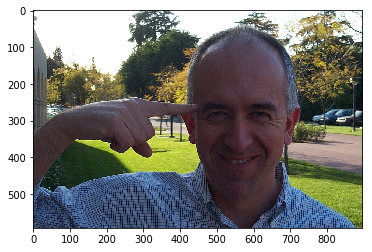

In [0]:
# Load an image
# for example, loading the image with index 1
one_image = load_image(metadata[1].image_path())

%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()

# Show original image
# OpenCV loads images with color channels
# in BGR order. So we need to reverse them everytime we use matplotlib to show the image.
# Otherwise you see the image in false colour
#plt.imshow(one_image)[...,::-1]
plt.imshow(one_image)


##### 3. A function to get the face bounding box x_min, x_max, y_min and y_max of input image using the face detection model given an image read using cv2.imread.


In [0]:
def face_bb(test_img):
    img_height =512
    img_width = 512
    img_channels = 3
    _CONF = 0.60
    _IOU = 0.15
    coords = 'centroids' # Whether the box coordinates to be used as targets for the model should be in the 'centroids' or 'minmax' format, see documentation
    normalize_coords = True
    org_height = test_img.shape[0]
    org_width = test_img.shape[1]
    test_img = cv2.resize(test_img, (512, 512))
    test_img_input = np.expand_dims(test_img,axis=0)
    y_pred = model.predict(test_img_input)
    y_pred_decoded = decode_y2(y_pred,
                                 confidence_thresh=_CONF,
                                iou_threshold=_IOU,
                                top_k='all',
                                input_coords=coords,
                                normalize_coords=normalize_coords,
                                img_height=img_height,
                                img_width=img_width)
    result = y_pred_decoded[0][0]
    det_label = result[0]
    det_conf = result[1]
    det_xmin = result[2]
    det_xmax = result[3]
    det_ymin = result[4]
    det_ymax = result[5]
    #Converting to integers as the indexes to images are only integers
    bb = [int(det_xmin),int(det_xmax),int(det_ymin),int(det_ymax)]
    return bb

# 2. Write a function to get the resized cropped out face of an input image from the path given using the face_bb() function defined above. - 5 Marks
Hint: The face_bb() function gives a list of bounding box co-ordinate values like **[x_min,x_max,y_min,y_max]**. Use **cv2.imread()** to load an image from the image path and pass it to the face_bb function as input. You can crop an image by simply accessing the specific values of the image matrix using the co-ordinates as the boundary indexes. But, before cropping we have to resize the input image to (512,512) like done in the **face_bb()** function as the bounding box co-ordinates are for the resized image. A simple crop can be implemented on the resized image by doing **"image[y_min:y_max,x_min:x_max,:]"** . 
You have to then resize the cropped image to a fixed size of (96,96). You can do that using the **cv2.resize()** function again. It takes the second argument as (96,96) this time. 

In [0]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

In [0]:
import bz2
import os

from urllib.request import urlopen

def download_landmarks(dst_file):
    url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
    decompressor = bz2.BZ2Decompressor()
    
    with urlopen(url) as src, open(dst_file, 'wb') as dst:
        data = src.read(1024)
        while len(data) > 0:
            dst.write(decompressor.decompress(data))
            data = src.read(1024)

dst_dir = 'models'
dst_file = os.path.join(dst_dir, 'landmarks.dat')

if not os.path.exists(dst_file):
    os.makedirs(dst_dir)
    download_landmarks(dst_file)

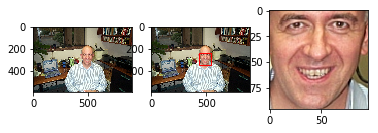

In [0]:
# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/landmarks.dat')

# Load an image
img_orig = load_image(metadata[2].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(img_orig)

# Transform image using specified face landmark indices and crop image to 96x96
img_aligned = alignment.align(96, img_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(img_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(img_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(img_aligned);

In [0]:
#def get_face(img_path):
    
    ###
    ### WRITE YOUR CODE HERE
    ###

#    return crop_img

In [0]:
#def image_align(img_path):
#  img = load_image(img_path)
#  bb = alignment.getLargestFaceBoundingBox(img)
#  img_aligned = alignment.align(96, img, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)
#  return img_aligned

In [0]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# 3. Write code to load 2nd and 3rd images in the metadata using load_image() and show each image and its cropped version side by side for comparison using matplotlib imshow - 7.5 Marks

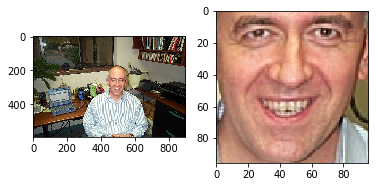

In [0]:
plt.subplot(121)
two_image = load_image(metadata[2].image_path())
plt.imshow(two_image)

plt.subplot(122)
two_image = load_image(metadata[2].image_path())
two_image = align_image(two_image)
plt.imshow(two_image)

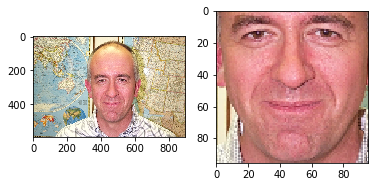

In [0]:
plt.subplot(121)
three_image = load_image(metadata[3].image_path())
plt.imshow(three_image)

plt.subplot(122)
three_image = load_image(metadata[3].image_path())
three_image = align_image(three_image)
plt.imshow(three_image)

### Generate embeddings for each image in the dataset

Given below is an example to load the first image in the metadata and get its embedding vector from the pre-trained model. 

#### Get embedding vector for first image in the metadata using the pre-trained model

In [0]:
# Align the image
#cropped_img = get_face(metadata[0].image_path())
cropped_img = load_image(metadata[0].image_path())
cropped_img = align_image(cropped_img)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (cropped_img / 255.).astype(np.float32)

# obtain embedding vector for an image
embedding_vector = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

print(embedding_vector.shape)

(128,)


# 4. Write code to iterate through metadata and create embeddings for each image using nn4_small2_pretrained.predict() and store in a list with name `embeddings` - 5 marks

If there is any error in reading any image in the dataset, fill the emebdding vector of that image with 128-zeroes as the final embedding from the model is of length 128.
Hint: Don't forget to use numpy's expand_dims funtion to convert each image into the shape (1,96,96,3) and take the 0th element of the prediction from the model as the embedding of the image. 

In [0]:
embeddings = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    if(type(img) != type(None)):
      img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
      embeddings[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]  

In [0]:
embeddings[0]

array([ 0.07772958,  0.1078655 , -0.01213643, -0.03897164, -0.05285567,
        0.02762951, -0.03268414, -0.10128584, -0.10184441, -0.01261166,
        0.17977518, -0.09110659,  0.0083497 ,  0.12425771,  0.03155538,
        0.11789326,  0.02709625,  0.11077529,  0.03774699, -0.12514071,
        0.09348851,  0.18799415, -0.0340033 , -0.12903874, -0.02814643,
        0.08760664,  0.03415683, -0.01727446,  0.10704519,  0.13522589,
       -0.11051022,  0.04317907,  0.0077971 , -0.04914104,  0.08843464,
        0.05614814,  0.00141106, -0.00953281,  0.15795372,  0.12252362,
       -0.16538841,  0.0926896 , -0.03426242,  0.08244542,  0.02036631,
        0.13911441,  0.09115561, -0.11542455, -0.17512594, -0.15676872,
        0.0437269 ,  0.12390393, -0.10487306,  0.07503484, -0.12511629,
        0.03986964,  0.06373495,  0.02998263, -0.04205441,  0.12949786,
        0.02150008, -0.08594355,  0.10668696,  0.01614605,  0.06216525,
       -0.09890258,  0.0228999 ,  0.03961021,  0.11415149,  0.13

#### Write code to get the distance between the respective embeddings given 2 pairs of images.

Consider distance metric as "Squared L2 distance"

squared l2 distance between 2 points (x1, y1) and (x2, y2) = (x1-x2)^2 + (y1-y2)^2



# 5. Plot images and get distance between the pairs given below. - 5 Marks

1. 10,12 and 10,131

2. 30,31 and 30,100

3. 70,72 and 70,115

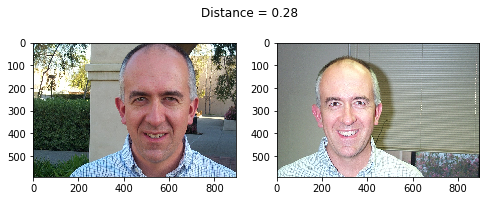

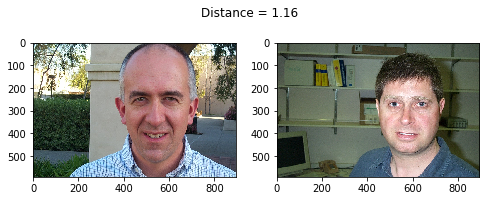

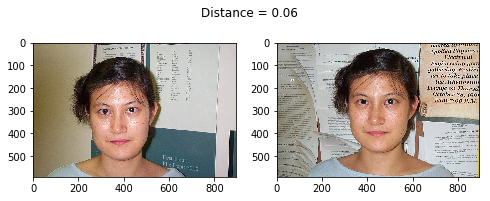

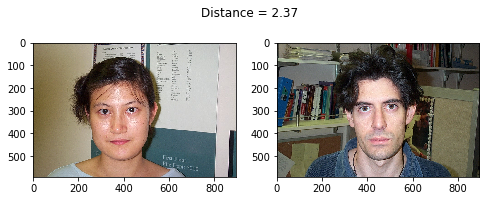

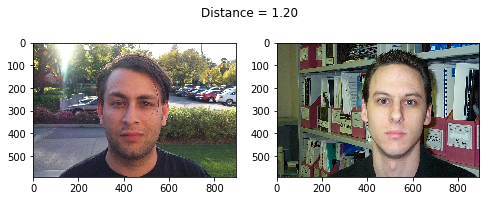

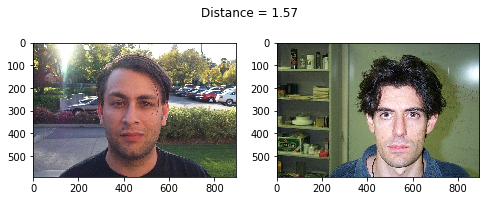

In [0]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(10, 12)
show_pair(10, 131)
show_pair(30, 31)
show_pair(30, 100)
show_pair(70, 72)
show_pair(70, 115)

#### Now lets build a simple fully connected neural network classifier to predict person in the given image. 

If you observe distances between more pairs the difference is not constant between opposite pairs. So we train a fully connected neural network with very limited dataset to classiffy each embedding into the person. Lets prepare the data for training a fully connected neural network using keras

In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [0]:
targets = np.array([(m.name) for m in metadata])

In [0]:
targets

array(['subject_8', 'subject_8', 'subject_8', 'subject_8', 'subject_8',
       'subject_8', 'subject_8', 'subject_8', 'subject_8', 'subject_8',
       'subject_8', 'subject_8', 'subject_8', 'subject_8', 'subject_8',
       'subject_8', 'subject_8', 'subject_8', 'subject_8', 'subject_8',
       'subject_8', 'subject_8', 'subject_8', 'subject_8', 'subject_8',
       'subject_8', 'subject_8', 'subject_8', 'subject_8', 'subject_1',
       'subject_1', 'subject_1', 'subject_1', 'subject_1', 'subject_1',
       'subject_1', 'subject_1', 'subject_1', 'subject_1', 'subject_1',
       'subject_1', 'subject_1', 'subject_1', 'subject_1', 'subject_1',
       'subject_1', 'subject_1', 'subject_1', 'subject_1', 'subject_1',
       'subject_1', 'subject_9', 'subject_9', 'subject_9', 'subject_9',
       'subject_9', 'subject_9', 'subject_9', 'subject_9', 'subject_9',
       'subject_9', 'subject_9', 'subject_9', 'subject_9', 'subject_9',
       'subject_9', 'subject_9', 'subject_9', 'subject_9', 'subj

In [0]:
integer_encoded = le.fit_transform(targets)

In [0]:
integer_encoded

array([ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10,  4,  4,  4,  4,  4,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  5,  5,  5,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  8,  8,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7])

In [243]:
import keras

#targets = np.array([int(m.name) for m in metadata])
targets = np.array([(m.name) for m in metadata])
integer_encoded = le.fit_transform(targets)

#num_classes = 11
# convert class vectors to one-hot encodings
y = keras.utils.to_categorical(integer_encoded, num_classes=None)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

## checking the shapes of metaadata and test and train sets
print(metadata.shape)
print(train_idx.shape)
print(test_idx.shape)


# one half as train examples of 10 identities
X_train = embeddings[train_idx]
X_test = embeddings[test_idx]


y_train = y[train_idx]
y_test = y[test_idx]

print(X_train.shape)
# svc = LinearSVC()

(201,)
(201,)
(201,)
(100, 128)


In [245]:
print(X_train[0].shape)

(128,)


# 6. Build a 1 layered fully connected neural network using keras and report the accuracy - 7.5 marks
Hint: Create only one layer with 11 neurons as we have 11 classes and mention the input_dim as 128 as the embeddings are of 128 length. Use a small batch size like 4 and use softmax as the activation function of the layer. 
You might have to train upto 80 epochs to get decent accuracy. You can use an Adam optimizer for the training part

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense
# Neural network
model = Sequential()
model.add(Dense(128, input_dim=128, activation='relu'))
model.add(Dense(11, activation='relu'))
model.add(Dense(11, activation='softmax'))

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [250]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_17 (Dense)             (None, 11)                1419      
_________________________________________________________________
dense_18 (Dense)             (None, 11)                132       
Total params: 18,063
Trainable params: 18,063
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Store Training Results
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', patience=50, verbose=1, mode='auto')
callback_list = [early_stopping]

In [252]:
batch_size = 4
nb_epochs = 80
history = model.fit(X_train,y_train,
                    epochs=80, 
                    validation_data=(X_test, y_test),
                    verbose = 1,
                    initial_epoch=0,
                    callbacks=callback_list)

Train on 100 samples, validate on 101 samples
Epoch 1/80
100/100 [==============================] - 4s 36ms/step - loss: 2.3963 - acc: 0.0700 - val_loss: 2.3523 - val_acc: 0.2277
Epoch 2/80
100/100 [==============================] - 0s 371us/step - loss: 2.3430 - acc: 0.2600 - val_loss: 2.3134 - val_acc: 0.4851
Epoch 3/80
100/100 [==============================] - 0s 397us/step - loss: 2.3009 - acc: 0.5900 - val_loss: 2.2673 - val_acc: 0.7327
Epoch 4/80
100/100 [==============================] - 0s 375us/step - loss: 2.2529 - acc: 0.7300 - val_loss: 2.2194 - val_acc: 0.7426
Epoch 5/80
100/100 [==============================] - 0s 344us/step - loss: 2.2018 - acc: 0.7700 - val_loss: 2.1685 - val_acc: 0.7525
Epoch 6/80
100/100 [==============================] - 0s 354us/step - loss: 2.1482 - acc: 0.7600 - val_loss: 2.1122 - val_acc: 0.7228
Epoch 7/80
100/100 [==============================] - 0s 384us/step - loss: 2.0900 - acc: 0.7300 - val_loss: 2.0519 - val_acc: 0.6832
Epoch 8/80
100/10

# 7.  Test the classifier 

Take 35th image from test set and plot the image, report to which person(folder name in dataset) the image belongs to.

In [0]:
os.chdir('/content')

In [0]:
os.chdir('files_required_for_face_recognition')

In [0]:
# str(model.predict([test_X[i].reshape(1,test_X[i].shape[0])]

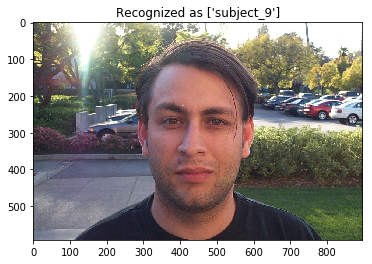

In [325]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 35

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = model.predict(X_test[example_idx].reshape(1,X_test[example_idx].shape[0]))
example_class = np.argmax(example_prediction)
example_identity = le.inverse_transform([example_class])

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');

## Optional Exercise - For people who are familiar with SVMs, you can use an SVM classifier(If you already know how to use the scikit-learn package for it) to do this last part being done by the fully connected neural network.

(201,)
(201,)
(201,)
SVM accuracy = 0.9801980198019802


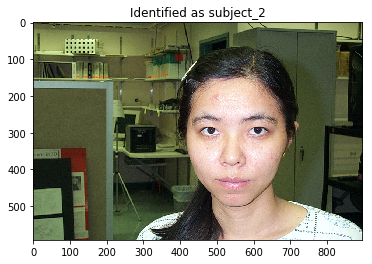

In [293]:
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

## checking the shapes of metaadata and test and train sets
print(metadata.shape)
print(train_idx.shape)
print(test_idx.shape)


# one half as train examples of 10 identities
X_train = embeddings[train_idx]
# another half as test examples of 10 identities
X_test = embeddings[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

svc = LinearSVC()

svc.fit(X_train, y_train)

acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'SVM accuracy = {acc_svc}')

import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 44

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc.predict([embeddings[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');